# 1. Simulation

This part is a discrete simulation of a gas diffusion in a open area.
The gaz is continuously released from a source and diffuses in the area.

Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from itertools import combinations_with_replacement


Define a builder class to create the simulation environment

In [2]:
class FickDiffusionBuilder():

    def __init__(self):
        self.size = (10, 10)

        self.points = (50, 50)
        
        self.source_rate = 2
        
        self.source_position = (5, 5)
        
        self.dt = 0.1
        
        self.D = 1

    # Set the size of the grid
    def set_size(self, size):
        self.size = size
        return self

    # Set the grid resolution (number of points in each dimension)
    def set_points(self, points):
        self.points = points
        return self

    # Source rate is the rate at which the source emits particles per second
    def set_source_rate(self, source_rate):
        self.source_rate = source_rate
        return self
    
    def set_source_position(self, source_position):
        self.source_position = source_position
        return self

    # Set the time step of the simulation in seconds (dt)
    def set_time_step(self, dt):
        self.dt = dt
        return self

    # Set the diffusion coefficient of the particles in the medium per second
    def set_diffusion_coefficient(self, D):
        self.D = D
        return self

    def build(self):
        return FickDiffusion(self.size, self.points, self.source_rate, self.source_position, self.dt, self.D)

We need to place somewhere the pseudo sensors that will be used to measure the concentration of the gaz in the area at different distances. In order to have the greatest distance coverage, we place then on the longest distance that separates the source from the border of the area. For that, we need to calculate the discrete line between two points. We will use the Bresenham algorithm to do that.

In [3]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy 

    while True:
        points.append((x0, y0))

        if x0 == x1 and y0 == y1:
            break
               
        e2 = 2 * err
        if e2 >= dy:  
            err += dy
            x0 += sx
        if e2 <= dx:  
            err += dx
            y0 += sy
            
    return np.array(points)

Simulate gas diffusion in a plane following Fick's 2nd law of diffusion :

$$
\frac{\delta C}{\delta t} = D \nabla^2 C
$$

where $C$ is the concentration of the gas, $D$ is the diffusion coefficient and $\nabla^2 C$ is the Laplacian operator : 

$$
\nabla^2 C = \frac{\delta^2 C}{\delta x^2} + \frac{\delta^2 C}{\delta y^2}
$$

Using the finite difference method, we can approximate the Laplacian operator as follows :

$$
\frac{\delta^2 C}{\delta x^2} \approx \frac{C_{i+1,j} - 2C_{i,j} + C_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\delta^2 C}{\delta y^2} \approx \frac{C_{i,j+1} - 2C_{i,j} + C_{i,j-1}}{\Delta y^2}
$$

where $\Delta x$ and $\Delta y$ are the steps in the $x$ and $y$ directions.


In [4]:
# This function is used to diffuse the gas in the area using the Fick's second law of diffusion
def diffuse(C, D, dt, dx, dy):
    # Laplacian of C
    d2C_dx2 = (np.roll(C, 1, axis=0) - 2 * C + np.roll(C, -1, axis=0)) / dx**2
    d2C_dy2 = (np.roll(C, 1, axis=1) - 2 * C + np.roll(C, -1, axis=1)) / dy**2
    # We use np.roll since it is faster than for loops

    # Diffusion equation
    dC_dt = D * (d2C_dx2 + d2C_dy2)
        
    # Time integration
    C += dt * dC_dt
        
    # Boundary conditions (necessary in order to use np.roll + simulate an open area)
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

    return C

Since our simulation is dealing with partial differential equations, we need to use a numerical method to solve it. We will use the finite difference method to solve the diffusion equation. However we have to ensure the stability of calculation by respecting the Courant-Friedrichs-Lewy (CFL) condition :

$$
\frac{D \Delta t}{\Delta x^2} + \frac{D \Delta t}{\Delta y^2} \leq \frac{1}{2}
$$

where $\Delta t$ is the time step and $D$ is the diffusion coefficient.


In [5]:
def get_courant_friedrichs_lewy_coefficient(D, dt, dx, dy):
    return ((D * dt) / (dx**2)) + ((D * dt) / (dy**2))

Since we will diffuse the gaz at a single point in the area at a constant rate, we have the simple function :

In [6]:
def release_gaz(C, source_x, source_y, source_rate):
    C[source_x, source_y] += source_rate
    return C

Here is the wrapping class that will simulate the gas diffusion in the area.

In [7]:
class FickDiffusion():
    def __init__(self, size, points, source_rate, source_position, dt, D):
        # Size of the area
        self.length = size[0]
        self.width = size[1]
    
        # Number of grid points
        self.nx = points[0]
        self.ny = points[1]

        # Grid spacing
        self.dx = self.length / self.nx
        self.dy = self.width / self.ny
        
        # Time step
        self.dt = dt

        # Gas diffusion coefficient
        self.D = D * dt

        courant_friedrichs_lewy = get_courant_friedrichs_lewy_coefficient(self.D, self.dt, self.dx, self.dy)

        if courant_friedrichs_lewy > 0.5:
            raise ValueError(f"Courant-Friedrichs-Lewy condition not met ({courant_friedrichs_lewy} > 0.5), please reduce the time step or increase the grid resolution")
        
        # Source release rate
        self.source_rate = source_rate * self.dt
       
        # Source location (offset from the center)
        self.source_x, self.source_y = self.get_grid_position(source_position[0], source_position[1])

        # Pseudo-sensors diagonal line
        self.diagonal = self.get_diagonal_line()       

    def get_grid_position(self, x, y):
        """
        Convert the real-world coordinates to grid coordinates
        """
        return (int(x / self.dx), int(y / self.dy))

    def animate(self, final_time, source_start=0, source_end=None):
        """
        Animate the diffusion of gas in the area for a given time
        and return the animation object
        """

        C = np.zeros((self.nx, self.ny))

        if source_end is None:
            source_end = final_time

        fig, ax = plt.subplots()

        C = self.release_gaz(C)  # Necessary for imshow to work properly
        im = ax.imshow(C, cmap='hot', interpolation='nearest', animated=True)
        
        text_label = ax.text(0.5, 1.01, '', transform=ax.transAxes, ha="center", va="bottom")

        
        def animation_function(i):
            """
            Animation callback function that updates the concentration of gas in the area.
            """
            nonlocal C

            t = i * self.dt

            if t >= source_start and t <= source_end:
                C = self.release_gaz(C)

            C = self.diffuse(C)

            im.set_array(C)
            
            text_label.set_text(f"Frame {i} - Time {i*self.dt:.2f}s")

            return im,
            

        ani = animation.FuncAnimation(fig, animation_function, frames=range(int(final_time//self.dt)), interval=int(self.dt*1000), blit=True)
        return ani

    def simulate(self, final_time, source_start=0, source_end=None):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the pseudo-sensor data
        """

        C = np.zeros((self.nx, self.ny))

        iterations = int(final_time//self.dt)

        # Compute the real coordinates of the pseudo-sensors
        real_coordinates = self.diagonal.copy() * np.array([self.dx, self.dy])

        # Create the different matrices to store the data
        values = np.zeros((len(self.diagonal), iterations))
        x = np.zeros_like(values)
        y = np.zeros_like(values)
        time = np.zeros_like(values)
        
        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time
            
        # Iterate over the time steps
        for i in range(iterations):
            t = i * self.dt

            # Release gas if the time is within the source start and end time
            if t >= source_start and t <= source_end:
                C = self.release_gaz(C)

            # Diffuse the gas in the area
            C = self.diffuse(C)

            # Collect the pseudo-sensor data
            for j, (map_coordinates, real_coordinate) in enumerate(zip(self.diagonal, real_coordinates)):
                x[j, i] = real_coordinate[0]
                y[j, i] = real_coordinate[1]
                time[j, i] = t
                values[j, i] = C[map_coordinates[0], map_coordinates[1]]

        return x, y, time, values

    def get_diagonal_line(self):
        x_0 = self.source_x
        y_0 = self.source_y

        if x_0 > self.nx - x_0:
            x_1 = 0
        else:
            x_1 = self.nx - 1

        if y_0 > self.ny - y_0:
            y_1 = 0
        else:
            y_1 = self.ny - 1

        return bresenham_line(x_0, y_0, x_1, y_1)[1:]
                
    def diffuse(self, C):
        return diffuse(C, self.D, self.dt, self.dx, self.dy)

    def release_gaz(self, C):
        return release_gaz(C, self.source_x, self.source_y, self.source_rate)
  

Show the animation of the gas diffusion in the area.

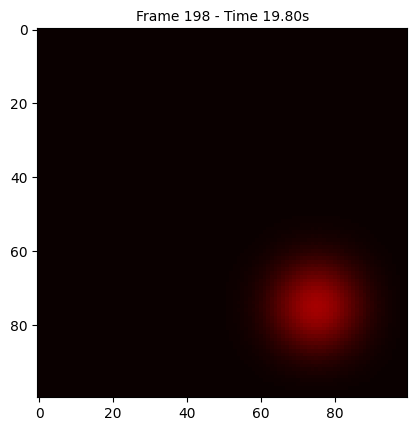

In [8]:
ani = (FickDiffusionBuilder()
    .set_points((100, 100))
    .set_size((20, 20))
    .set_source_position((15,15))
    .build()
    .animate(20, source_end=10))

HTML(ani.to_html5_video())


Let's generate for multiple diffusion coefficients $D$ and store the results in a CSV file for later use.


In [9]:
# Create a list of diffusion coefficients to simulate
Ds = np.linspace(0.1, 1, 20)

# Store the vectors in a list to concatenate them later
# This is faster than appending to numpy arrays in a loop.
diffusion_coefficients = []
values = []
x = []
y = []
time = []
distances_to_source = []
source_positions_x = []
source_positions_y = []

size = None

for source_x, source_y in combinations_with_replacement(np.linspace(5, 15, 5), 2):
    for D in Ds:
        print(f"Simulating source at ({source_x}, {source_y}) with D={D}")

        current_x, current_y, current_time, current_values = (FickDiffusionBuilder()
            .set_points((100, 100))
            .set_size((20, 20))
            .set_source_position((source_x, source_y))
            .set_diffusion_coefficient(D)
            .build()
            .simulate(20, source_end=10))

        current_D = np.ones_like(current_values) * D
        source_positions_x.append(np.ones_like(current_values) * source_x)
        source_positions_y.append(np.ones_like(current_values) * source_y)

        diffusion_coefficients.append(current_D)

        values.append(current_values)
        x.append(current_x)
        y.append(current_y)
        time.append(current_time)

        distances_to_source.append(np.sqrt((current_x - source_x)**2 + (current_y - source_y)**2))

        print(f"Sensor data shape: {current_values.shape}, source position: ({source_x}, {source_y})")

        for i in range(current_values.shape[0]):
            if current_values[i].max() > 0:
                print(f"Pos : ({current_x[i, 0]:.2f}, {current_y[i, 0]:.2f}) - d: {distances_to_source[-1][i, 0]:.2f} - v: {current_values[i].mean()}")
                

Simulating source at (5.0, 5.0) with D=0.1
Sensor data shape: (74, 199), source position: (5.0, 5.0)
Pos : (5.20, 5.20) - d: 0.28 - v: 0.4694693641870913
Pos : (5.40, 5.40) - d: 0.57 - v: 0.15626051858680287
Pos : (5.60, 5.60) - d: 0.85 - v: 0.04794207545111594
Pos : (5.80, 5.80) - d: 1.13 - v: 0.012973826236101096
Pos : (6.00, 6.00) - d: 1.41 - v: 0.0030698550572558947
Pos : (6.20, 6.20) - d: 1.70 - v: 0.0006349753382267133
Pos : (6.40, 6.40) - d: 1.98 - v: 0.0001149430690877812
Pos : (6.60, 6.60) - d: 2.26 - v: 1.8228036518812784e-05
Pos : (6.80, 6.80) - d: 2.55 - v: 2.534969968269163e-06
Pos : (7.00, 7.00) - d: 2.83 - v: 3.095720722631787e-07
Pos : (7.20, 7.20) - d: 3.11 - v: 3.3256273065405066e-08
Pos : (7.40, 7.40) - d: 3.39 - v: 3.149504128761421e-09
Pos : (7.60, 7.60) - d: 3.68 - v: 2.635854765292164e-10
Pos : (7.80, 7.80) - d: 3.96 - v: 1.9545060433819387e-11
Pos : (8.00, 8.00) - d: 4.24 - v: 1.2874981030765028e-12
Pos : (8.20, 8.20) - d: 4.53 - v: 7.554592607401239e-14
Pos : (

One information that could be useful is the time it takes for the gas to reach a certain distance. Since we have signals from multiple sensors, we can determine that by the relative offset between a reference signal and the other signals.

$$
\text{corr}(f, g)(k) = \sum_{i=1}^{N} f(i) \cdot g(i+k)
$$
where:
- $f$ and $g$ are two functions representing discrete signals
- $k$ is the relative offset between the two functions
- $N$ is the length of the signals

The the maximum of the correlation function correspond to where the two signals are the most similar. This is the relative offset between the two signals.

$$
\text{relative offset} = \text{argmax}(\text{corr}(f, g)(k))
$$

In [10]:
def get_relative_offset(signal_1, signal_2):
    """
    Get the relative offset between two signals using cross-correlation
    """
    correlation = sp.signal.correlate(signal_1, signal_2, mode='full')
    offset = np.argmax(correlation) - len(signal_1) + 1
    return offset

In [11]:
def get_relative_offsets(values):
    """
    Get the relative offsets between a list of signals
    where the first signal is the reference signal.
    The axis 0 of the signals array should be the sensors
    and the axis 1 should be the time.
    """

    # We use the first signal as a reference but we could use any other signal
    reference_signal = values[0] 
    
    offsets = np.zeros(len(values))

    n, p = values.shape

    for i in range(n):
        # The offset of the reference signal is 0 obviously, so we skip it
        if i == 0:
            offsets[i] = 0
        else:
            offsets[i] = get_relative_offset(reference_signal, values[i])

    return offsets.repeat(p).reshape(n, p)

Put the data into a data frame and save it to a CSV file.

In [12]:
relative_offsets = [get_relative_offsets(v) for v in values]


# Concatenate all the vectors and create the data frame
data_frame = pd.DataFrame({
    "diffusion_coefficients": np.concatenate(diffusion_coefficients).flatten(),
    "x": np.concatenate(x).flatten(),
    "y": np.concatenate(y).flatten(),
    "time": np.concatenate(time).flatten(),
    "values": np.concatenate(values).flatten(),
    "distances_to_source": np.concatenate(distances_to_source).flatten(),
    "relative_offsets": np.concatenate(relative_offsets).flatten(),
    "source_positions_x": np.concatenate(source_positions_x).flatten(),
    "source_positions_y": np.concatenate(source_positions_y).flatten(),
})

# Save the data frame to a CSV file
data_frame.to_csv("data.csv", index=False)